In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
np.random.seed(0)
N = 200
x = np.arange(1, N+1) / N
eps = np.random.normal(0, np.sqrt(0.01), size=N)
y = 2 * x + 1 + eps

In [28]:
x = np.hstack([np.ones((N, 1)), x.reshape(-1, 1)])
l = lambda w, x, y: np.mean((y - x @ w) ** 2)
grad_l = lambda w, x, y: -2 * x.T @ (y - x @ w) / len(y)

def gradient_descent(l, grad_l, Theta0, X, Y, lr=1e-3, epochs=500):
    Theta = Theta0
    losses = []
    thetas = []
    for k in range(epochs):
        grad = grad_l(Theta, X, Y)
        Theta -= lr * grad
        losses.append(l(Theta, X, Y))
        thetas.append(Theta.copy())
    return thetas, losses

def sgd(l, grad_l, Theta0, X, Y, batch_size=64, lr=1e-3, epochs=500):
    Theta = Theta0
    N = len(Y)
    losses = []
    thetas = []
    for epoch in range(epochs):
        indices = np.random.permutation(N)
        for start in range(0, N, batch_size):
            batch_idx = indices[start:start+batch_size]
            Xb, Yb = X[batch_idx], Y[batch_idx]
            grad = grad_l(Theta, Xb, Yb)
            Theta -= lr * grad
        losses.append(l(Theta, X, Y))
        thetas.append(Theta.copy())
    return thetas, losses

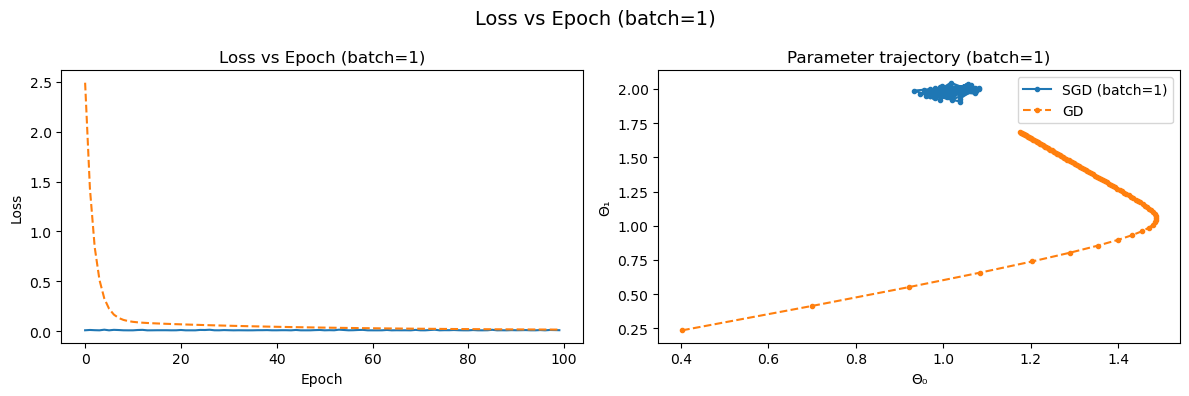

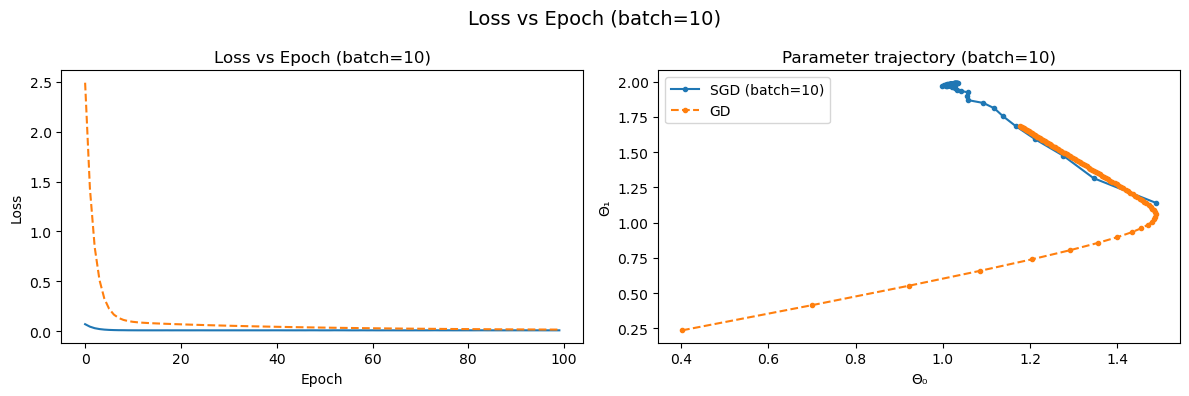

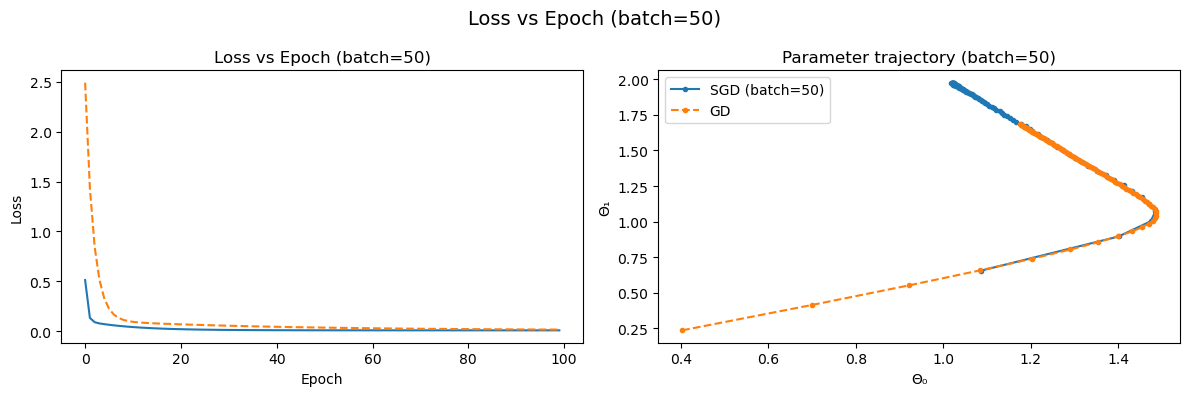

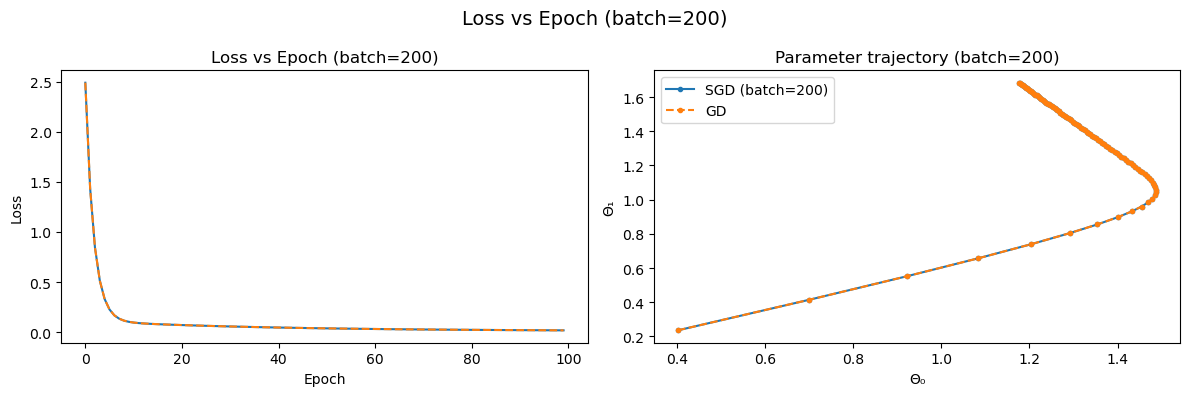

In [33]:
thetasGD, lossesGD = gradient_descent(l, grad_l, np.zeros(2), x, y, lr=0.1, epochs=100)
batches = [1, 10, 50, N]
for batch_size in batches:
    thetasSGD, lossesSGD = sgd(l, grad_l, np.zeros(2), x, y, batch_size=batch_size, lr=0.1, epochs=100)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'Loss vs Epoch (batch={batch_size})', fontsize=14)

    axes[0].plot(lossesSGD, label=f'SGD (batch={batch_size})')
    axes[0].plot(lossesGD, label='GD', linestyle='--')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'Loss vs Epoch (batch={batch_size})')

    axes[1].plot([th[0] for th in thetasSGD], [th[1] for th in thetasSGD], 'o-', label=f'SGD (batch={batch_size})', markersize=3)
    axes[1].plot([th[0] for th in thetasGD], [th[1] for th in thetasGD], 'o--', label='GD', markersize=3)
    axes[1].set_xlabel('Θ₀')
    axes[1].set_ylabel('Θ₁')
    axes[1].set_title(f'Parameter trajectory (batch={batch_size})')   
    axes[1].legend()
    plt.tight_layout()
    plt.show()